# Quickstart: C4 Model Generation & Evaluation

This notebook shows:
1) How to visualize the LangGraph workflow  
2) How to generate C4 artifacts for **one brief**  
3) How to batch-run across **all briefs** in `data/briefs/` and evaluate


In [1]:
from dotenv import load_dotenv
import os, sys, platform

load_dotenv()  # reads .env

print("Python:", sys.version.split()[0], "| Platform:", platform.system())
for key in ["OPENAI_API_KEY","GOOGLE_API_KEY","DEEPSEEK_API_KEY","XAI_API_KEY"]:
    print(f"{key} set? ", "✅" if os.getenv(key) else "⚠️ missing")


Python: 3.10.11 | Platform: Windows
OPENAI_API_KEY set?  ✅
GOOGLE_API_KEY set?  ✅
DEEPSEEK_API_KEY set?  ✅
XAI_API_KEY set?  ✅


c:\Users\kamil\Documents\Kamil\HICSS\repo\hicss-2025-c4-llm-agents\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 🏗️ Building graph with model: 'gpt-4o-mini' and analysis: 'collaborative' ---
--- ⚙️  Instantiating model: gpt-4o-mini ---
✅ LangGraph C4 Modeler compiled successfully with checkpointer!


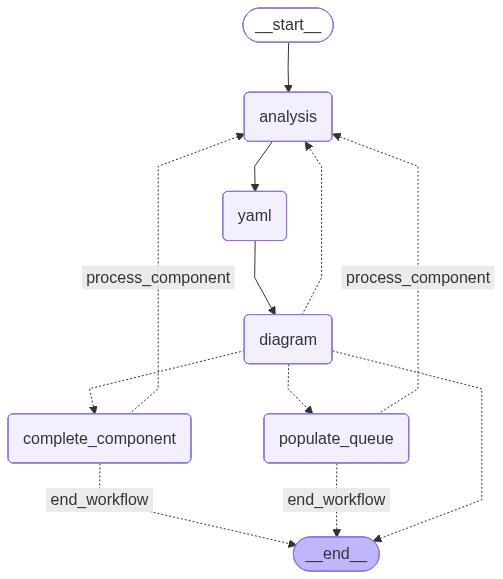

In [2]:
from IPython.display import Image, display
from c4modeler.experiments import build_app_from_config

# Build an app solely to draw the graph (no run needed)
app = build_app_from_config(
    model_name="gpt-4o-mini",
    analysis_method="collaborative",
    collab_rounds=2,
)

try:
    png_bytes = app.get_graph(xray=True).draw_mermaid_png()
    display(Image(png_bytes))
except Exception as e:
    print("Graph visualization unavailable in this environment:", e)


In [ ]:
from c4modeler.pipeline import generate_c4_for_brief
from c4modeler.utils import load_yaml

# Choose a brief (edit as needed)
brief_path = "../data/briefs/clinic-management-system.yaml"
brief_dict = load_yaml(brief_path)

c4_model, out_dir = generate_c4_for_brief(
    brief_dict,                 # dict is fine; pipeline will format prompt correctly
    model_name="gpt-4o-mini",   # pick from your llm.py map
    analysis_method="collaborative",  # or "simple"
    collab_rounds=2,
    results_dir="../data/results",
)

print("Artifacts saved to:", out_dir)

# Peek at what was produced
print("\nContext analysis preview:\n", (c4_model.get("context", {}) or {}).get("analysis", "")[:800], "...\n")
print("Has container YAML?", bool((c4_model.get("containers", {}) or {}).get("yaml_definition")))
print("Has container diagram?", bool((c4_model.get("containers", {}) or {}).get("diagram")))


--- 🏗️ Building graph with model: 'gpt-4o-mini' and analysis: 'collaborative' ---
--- ⚙️  Instantiating model: gpt-4o-mini ---
✅ LangGraph C4 Modeler compiled successfully with checkpointer!
--- 🚀 Orchestrating Collaborative Analysis ---
--- Selecting Team: Context Level ---
--- Invoking subgraph for: context ---
--- 🗣️  Turn: Product_Owner on C4 Level: 'context' ---
--- 🗣️  Turn: Business_Analyst on C4 Level: 'context' ---
--- 🗣️  Turn: Lead_Software_Architect on C4 Level: 'context' ---
--- 🗣️  Turn: Product_Owner on C4 Level: 'context' ---
--- 🗣️  Turn: Business_Analyst on C4 Level: 'context' ---
--- 🗣️  Turn: Lead_Software_Architect on C4 Level: 'context' ---
--- ✅ Collaboration Complete: Max rounds (2) reached. ---
--- 🔬 Generating Final Analysis Report ---
--- ✅ Subgraph complete. Updating main C4 model for: context ---
--- 📝 Generating Context Level YAML ---
--- 🎨 Generating Context Level Diagram ---
--- 🚀 Orchestrating Collaborative Analysis ---
--- Selecting Team: Container Lev

In [5]:
from c4modeler.experiments import (
    build_app_from_config,
    run_all_experiments,
    load_briefs_from_dir,
)

# Load all briefs as raw YAML strings
system_briefs = load_briefs_from_dir("../data/briefs")

# Define a small experiment config
EXPERIMENT_CONFIGS = [
    {
        "name": "GPT4omini_Collab_1r",
        "model_name": "gpt-4o-mini",
        "analysis_method": "collaborative",
        "collab_rounds": 1,
    },
]

all_experiment_results = {}
for cfg in EXPERIMENT_CONFIGS:
    print("\n" + "="*60)
    print(f"🚀 Starting Experiment: {cfg['name']}")
    print("="*60)

    app = build_app_from_config(
        model_name=cfg["model_name"],
        analysis_method=cfg["analysis_method"],
        collab_rounds=cfg["collab_rounds"],
    )
    results = run_all_experiments(app_instance=app, system_briefs_data=system_briefs)
    all_experiment_results[cfg["name"]] = results

print("\n\n🎉 Generation complete for all briefs.")



🚀 Starting Experiment: GPT4omini_Collab_1r
--- 🏗️ Building graph with model: 'gpt-4o-mini' and analysis: 'collaborative' ---
--- ⚙️  Instantiating model: gpt-4o-mini ---
✅ LangGraph C4 Modeler compiled successfully with checkpointer!

--- 🚀 Starting C4 Model Generation Experiments ---


--- Processing: clinic-management-system ---


--- LangGraph Thread ID: 20250922-230714-clinic-management-system-b9447f3d ---
--- 🚀 Orchestrating Collaborative Analysis ---
--- Selecting Team: Context Level ---
--- Invoking subgraph for: context ---
--- 🗣️  Turn: Product_Owner on C4 Level: 'context' ---
--- 🗣️  Turn: Business_Analyst on C4 Level: 'context' ---
--- 🗣️  Turn: Lead_Software_Architect on C4 Level: 'context' ---
--- ✅ Collaboration Complete: Max rounds (1) reached. ---
--- 🔬 Generating Final Analysis Report ---
--- ✅ Subgraph complete. Updating main C4 model for: context ---

Node: analysis
--- 📝 Generating Context Level YAML ---

Node: yaml
--- 🎨 Generating Context Level Diagram ---

Node:

In [6]:
from c4modeler.experiments import run_all_evaluations

JUDGE_MODEL = "gemini-2.5-flash-preview-05-20"  # pick any from your llm.py

final_evaluation_summaries = {}
for cfg in EXPERIMENT_CONFIGS:
    name = cfg["name"]
    exp_results = all_experiment_results.get(name)
    if not exp_results:
        print(f"⚠️ No results for {name}; skipping.")
        continue

    summary = run_all_evaluations(
        experiment_results=exp_results,
        experiment_config=cfg,
        judge_model_name=JUDGE_MODEL,
    )
    final_evaluation_summaries[name] = summary

print("\n\n🎉 Evaluations completed.")



🔬 Running Evaluations (Judge: gemini-2.5-flash-preview-05-20) for experiment: GPT4omini_Collab_1r

--- Evaluating: clinic-management-system (thread 20250922-230714-clinic-management-system-b9447f3d) ---
  - Saved 1_context_analysis.md
  - Saved 1_context_definition.yaml
  - Saved 1_context_diagram.puml
  - Saved 2_container_analysis.md
  - Saved 2_container_definition.yaml
  - Saved 2_container_diagram.puml
  - Saved user_interface_ui_container_analysis.md
  - Saved user_interface_ui_container_definition.yaml
  - Saved user_interface_ui_container_diagram.puml
  - Saved patient_management_microservice_analysis.md
  - Saved patient_management_microservice_definition.yaml
  - Saved patient_management_microservice_diagram.puml
  - Saved appointment_management_microservice_analysis.md
  - Saved appointment_management_microservice_definition.yaml
  - Saved appointment_management_microservice_diagram.puml
  - Saved electronic_medical_records_emr_microservice_analysis.md
  - Saved electronic_

Key 'parameters' is not supported in schema, ignoring



--- Running Holistic Expert Critiques ---
⚖️ Evaluating Metric 7: Principal Architect's Critique...


Key 'parameters' is not supported in schema, ignoring


🛡️  Evaluating Metric 8: Security 'Red Team' Assessment...


📋 FINAL EVALUATION REPORT (Judge: gemini-2.5-flash-preview-05-20) 📋

{
  "evaluationMetadata": {
    "judgeModel": "gemini-2.5-flash-preview-05-20",
    "judgeModelTemperature": 0.0,
    "evaluationTimestamp": "2025-09-23T00:19:58.444832"
  },
  "compilationSuccess": {
    "metric": "Compilation Success Rate",
    "score": 45.45,
    "successful": 5,
    "total": 11,
    "details": [
      {
        "source": "1_Context",
        "status": "Compiled",
        "error": null
      },
      {
        "source": "2_Containers",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_da4660211ec140ffb6045830156ab3c7.puml"
      },
      {
        "source": "3_Component_User Interface (UI) Container",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_c9303d10978d4ec9a012e12012b67bed.puml"
      },
      {
        "source": "3_Component_Patient Manage

Key 'parameters' is not supported in schema, ignoring



--- Running Holistic Expert Critiques ---
⚖️ Evaluating Metric 7: Principal Architect's Critique...


Key 'parameters' is not supported in schema, ignoring


🛡️  Evaluating Metric 8: Security 'Red Team' Assessment...


📋 FINAL EVALUATION REPORT (Judge: gemini-2.5-flash-preview-05-20) 📋

{
  "evaluationMetadata": {
    "judgeModel": "gemini-2.5-flash-preview-05-20",
    "judgeModelTemperature": 0.0,
    "evaluationTimestamp": "2025-09-23T00:22:16.556986"
  },
  "compilationSuccess": {
    "metric": "Compilation Success Rate",
    "score": 27.27,
    "successful": 3,
    "total": 11,
    "details": [
      {
        "source": "1_Context",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_1aa0e32d0d01472fbbd9062bcd87ebe8.puml"
      },
      {
        "source": "2_Containers",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_693b90cdb4f0434b997ec5afffe1668a.puml"
      },
      {
        "source": "3_Component_Web Application (Self-Service Portal)",
        "status": "Compiled",
        "error": null
      },
      {
        "source": "3_Component_API Ga

Key 'parameters' is not supported in schema, ignoring



--- Running Holistic Expert Critiques ---
⚖️ Evaluating Metric 7: Principal Architect's Critique...


Key 'parameters' is not supported in schema, ignoring


🛡️  Evaluating Metric 8: Security 'Red Team' Assessment...


📋 FINAL EVALUATION REPORT (Judge: gemini-2.5-flash-preview-05-20) 📋

{
  "evaluationMetadata": {
    "judgeModel": "gemini-2.5-flash-preview-05-20",
    "judgeModelTemperature": 0.0,
    "evaluationTimestamp": "2025-09-23T00:24:22.928877"
  },
  "compilationSuccess": {
    "metric": "Compilation Success Rate",
    "score": 50.0,
    "successful": 5,
    "total": 10,
    "details": [
      {
        "source": "1_Context",
        "status": "Compiled",
        "error": null
      },
      {
        "source": "2_Containers",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_5d08def5863f4105aac747946c17193c.puml"
      },
      {
        "source": "3_Component_Frontend Web Application",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_a71fc3f9994e4fc1b146d982af8351bf.puml"
      },
      {
        "source": "3_Component_API Gateway",
      

Key 'parameters' is not supported in schema, ignoring



--- Running Holistic Expert Critiques ---
⚖️ Evaluating Metric 7: Principal Architect's Critique...


Key 'parameters' is not supported in schema, ignoring


🛡️  Evaluating Metric 8: Security 'Red Team' Assessment...


📋 FINAL EVALUATION REPORT (Judge: gemini-2.5-flash-preview-05-20) 📋

{
  "evaluationMetadata": {
    "judgeModel": "gemini-2.5-flash-preview-05-20",
    "judgeModelTemperature": 0.0,
    "evaluationTimestamp": "2025-09-23T00:26:54.544085"
  },
  "compilationSuccess": {
    "metric": "Compilation Success Rate",
    "score": 50.0,
    "successful": 4,
    "total": 8,
    "details": [
      {
        "source": "1_Context",
        "status": "Compiled",
        "error": null
      },
      {
        "source": "2_Containers",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_4dd70b4bf1164486917d6ff78d63f8bd.puml"
      },
      {
        "source": "3_Component_Web Application",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_f2f09b09d09e445eb7d7e07897163dca.puml"
      },
      {
        "source": "3_Component_Backend API",
        "status"

Key 'parameters' is not supported in schema, ignoring



--- Running Holistic Expert Critiques ---
⚖️ Evaluating Metric 7: Principal Architect's Critique...


Key 'parameters' is not supported in schema, ignoring


🛡️  Evaluating Metric 8: Security 'Red Team' Assessment...


📋 FINAL EVALUATION REPORT (Judge: gemini-2.5-flash-preview-05-20) 📋

{
  "evaluationMetadata": {
    "judgeModel": "gemini-2.5-flash-preview-05-20",
    "judgeModelTemperature": 0.0,
    "evaluationTimestamp": "2025-09-23T00:28:43.851654"
  },
  "compilationSuccess": {
    "metric": "Compilation Success Rate",
    "score": 80.0,
    "successful": 8,
    "total": 10,
    "details": [
      {
        "source": "1_Context",
        "status": "Compiled",
        "error": null
      },
      {
        "source": "2_Containers",
        "status": "Failed - Syntax Error",
        "error": "Warning: no image in temp_diagram_8ee4d5ac360945f19127148d1b1a6597.puml"
      },
      {
        "source": "3_Component_Web Application",
        "status": "Compiled",
        "error": null
      },
      {
        "source": "3_Component_API Gateway",
        "status": "Failed - Syntax Error",
        "error": "Some diagram description contains er

In [7]:
import json

for name, summary in final_evaluation_summaries.items():
    print("\n", "="*80)
    print("Experiment:", name)
    print("="*80)

    summaries = summary.get("summaries", {})
    if not summaries:
        print("No formatted summaries available; see raw reports.")
        continue

    for thread_id, s in summaries.items():
        print(f"\nThread: {thread_id}")
        try:
            print(json.dumps(s, indent=2))
        except Exception:
            print(s)



Experiment: GPT4omini_Collab_1r

Thread: 20250922-230714-clinic-management-system-b9447f3d
{
  "note": "No formatter available; returning full report.",
  "report": {
    "evaluationMetadata": {
      "judgeModel": "gemini-2.5-flash-preview-05-20",
      "judgeModelTemperature": 0.0,
      "evaluationTimestamp": "2025-09-23T00:19:58.444832"
    },
    "compilationSuccess": {
      "metric": "Compilation Success Rate",
      "score": 45.45,
      "successful": 5,
      "total": 11,
      "details": [
        {
          "source": "1_Context",
          "status": "Compiled",
          "error": null
        },
        {
          "source": "2_Containers",
          "status": "Failed - Syntax Error",
          "error": "Warning: no image in temp_diagram_da4660211ec140ffb6045830156ab3c7.puml"
        },
        {
          "source": "3_Component_User Interface (UI) Container",
          "status": "Failed - Syntax Error",
          "error": "Warning: no image in temp_diagram_c9303d10978d4ec